In [1]:
# Basic code to import and visualize BedMachine ice surface and bed elevation topography dataset

# Author: W. Sauthoff (sauthoff@mines.edu)

In [1]:
# install packages that are not pre-installed on CryoCloud

In [1]:
%pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install netcdf4

In [3]:
%pip install pysheds

  Using cached pysheds-0.3.5-py3-none-any.whl (89 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import packages
import datetime
import earthaccess
import geopandas as gpd
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
from pyproj import CRS, Transformer
import pysheds
from pysheds.grid import Grid
import rasterio
import rioxarray
from shapely.geometry import box
import xarray as xr

# Define data directories dependent on home environment (replace with your data directory file path(s))
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos/scripts'
    OUTPUT_DIR = '/home/jovyan/3_subglacial_modeling/output/subglacial_routing'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'

# Define utility functions
def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length
# replace with mdates.date2num?
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereograph
    to geodetic (lon, lat) coordinates
    
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

In [6]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()p

In [55]:
# Find ICESat-2 ATL15 r003 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    cloud_hosted=True)

Granules found: 40


In [56]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

 Opening 36 granules, approx size: 5.95 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/36 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/36 [00:00<?, ?it/s]

In [57]:
files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [66]:
# After viewing files, index the files you wish to open
print(files[14])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [67]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[14], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [68]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [69]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [70]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim="x")

In [71]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated y=0 vector of data
ATL15 = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim=("y"))

In [72]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

# Import datasets

In [18]:
# MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar V002 (Mouginot and others, 2017)
# https://doi.org/10.5067/AXE4121732AD
# https://nsidc.org/sites/default/files/nsidc-0709-v002-userguide.pdf
IMBIE_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_IMBIE_Antarctica_v02.shp')
# refined_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_Antarctica_v02.shp')
# ice_boundaries = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/IceBoundaries_Antarctica_v02.shp')
# grounded_ice_boundaries = ice_boundaries[ice_boundaries["TYPE"]=='GR']
IMBIE_basins

NAME    Regions Subregions TYPE  \
0     NaN    Islands        NaN   IS   
1    A-Ap       East       A-Ap   GR   
2    Ap-B       East       Ap-B   GR   
3     B-C       East        B-C   GR   
4    C-Cp       East       C-Cp   GR   
5    Cp-D       East       Cp-D   GR   
6    D-Dp       East       D-Dp   GR   
7    Dp-E       East       Dp-E   GR   
8    E-Ep       East       E-Ep   GR   
9    Ep-F       West       Ep-F   GR   
10    F-G       West        F-G   GR   
11    G-H       West        G-H   GR   
12   H-Hp       West       H-Hp   GR   
13   Hp-I  Peninsula       Hp-I   GR   
14  I-Ipp  Peninsula      I-Ipp   GR   
15  Ipp-J  Peninsula      Ipp-J   GR   
16  J-Jpp       West      J-Jpp   GR   
17  Jpp-K       East      Jpp-K   GR   
18    K-A       East        K-A   GR   

                                             geometry  
0   MULTIPOLYGON (((-217776.532 2130382.522, -2168...  
1   POLYGON ((1233919.752 1935020.761, 1237354.550...  
2   POLYGON ((1267480.529 1935993.733, 1261072.640...  
3   POLYGON ((1672255.018 -94566.965, 1625433.485 ...  
4   POLYGON ((2594276.532 -575938.016, 2594114.248...  
5   POLYGON ((2317315.872 -603916.511, 2321147.611...  
6   POLYGON ((1419962.788 -1124912.594, 1435793.14...  
7   POLYGON ((458049.880 -1586925.021, 458790.209 ...  
8   POLYGON ((385888.335 -1128116.870, 385900.076 ...  
9   POLYGON ((-578695.182 -1285897.642, -578945.60...  
10  POLYGON ((-1099110.890 -966140.129, -1089377.4...  
11  POLYGON ((-1515456.671 -545301.309, -1515230.3...  
12  POLYGON ((-1665853.445 206829.399, -1662779.24...  
13  MULTIPOLYGON (((-1981550.026 606779.819, -1980...  
14  POLYGON ((-2418949.539 1418837.511, -2418949.6...  
15  POLYGON ((-1584579.956 902423.000, -1584579.95...  
16  POLYGON ((-1187659.179 23095.994, -1199482.277...  
17  POLYGON ((-621202.971 771276.873, -620950.970 ...  
18  POLYGON ((-681761.563 1361890.885, -681258.113...

In [23]:
# Import subglacial lake outlines 
exec(open(SCRIPT_DIR + '/Sauthoff2024_outlines.py').read())

In [26]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [34]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


In [7]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')
# Display geopandas.Dataframe header/footer
Scripps_gl

Id                       Id_text  Area_km2  \
0      4                     Ice shelf  60302.95   
1      4                     Ice shelf   2394.87   
2      4                     Ice shelf  61814.32   
3      4                     Ice shelf   7205.19   
4      4                     Ice shelf   2127.50   
...   ..                           ...       ...   
1037   2  Ice rise or connected island     73.74   
1038   2  Ice rise or connected island     54.69   
1039   2  Ice rise or connected island     55.39   
1040   2  Ice rise or connected island    161.72   
1041   3               Isolated island     32.99   

                                               geometry  
0     POLYGON ((39947.724 2188914.445, 39750.037 218...  
1     POLYGON ((345050.528 2157574.155, 344433.035 2...  
2     POLYGON ((594089.423 2131075.000, 593996.426 2...  
3     POLYGON ((401537.254 2156506.717, 401408.904 2...  
4     POLYGON ((-377953.484 2048482.117, -377970.339...  
...                                                 ...  
1037  POLYGON ((2088836.654 655998.069, 2089014.564 ...  
1038  POLYGON ((-1594648.792 -284171.785, -1594838.8...  
1039  POLYGON ((-1596362.168 -444554.909, -1594639.9...  
1040  POLYGON ((2139578.346 1257450.000, 2139550.000...  
1041  POLYGON ((1941590.557 1603434.016, 1940462.839...  

[1042 rows x 4 columns]

In [8]:
Scripps_gl.Id_text.unique()

array(['Ice shelf', 'Isolated island', 'Ice rise or connected island',
       'Grounded ice or land'], dtype=object)

In [9]:
# Isolate specific ice types for plotting purposes
Scripps_iceshelf = Scripps_gl[Scripps_gl['Id_text'] == 'Ice shelf']
Scripps_isolatedisland = Scripps_gl[Scripps_gl['Id_text'] == 'Isolated island']
Scripps_icerise = Scripps_gl[Scripps_gl['Id_text'] == 'Ice rise or connected island']
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [10]:
# BedMachine Antarctica bed and surface topography v3
# https://nsidc.org/data/NSIDC-0756 
# More info: https://sites.uci.edu/morlighem/bedmachine-antarctica/
# Relocate download to data_dir

# Open Bedmachine netcdf dataset using xarray
BedMachine_ds = xr.open_dataset(DATA_DIR + '/beds/BedMachine/BedMachineAntarctica-v3.nc')

In [11]:
# # FIXME: temporary subsetting of data

# # Subset dataset to region of interest using data masks
# dataset = BedMachine_ds
# mask_x = (dataset.x >= xmin) & (dataset.x <= xmax)
# mask_y = (dataset.y >= ymin) & (dataset.y <= ymax)
# BedMachine_ds = dataset.where(mask_x & mask_y, drop=True)

In [12]:
# Use BedMachine bed topography for Zbed; static BedMachine surface topogrpahy for static Zsurf
BedMachine_ds = BedMachine_ds.assign(static_hydropotential_kPa = (9.8 * ((917*BedMachine_ds['surface']-BedMachine_ds['firn']) + (997-917)*BedMachine_ds['bed']))/1e3)

# Display xarray.Dataset metadata
BedMachine_ds

<xarray.Dataset>
Dimensions:                    (x: 13333, y: 13333)
Coordinates:
  * x                          (x) int32 -3333000 -3332500 ... 3332500 3333000
  * y                          (y) int32 3333000 3332500 ... -3332500 -3333000
Data variables:
    mapping                    |S1 ...
    mask                       (y, x) int8 ...
    firn                       (y, x) float32 ...
    surface                    (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    thickness                  (y, x) float32 ...
    bed                        (y, x) float32 -5.916e+03 ... -3.664e+03
    errbed                     (y, x) float32 ...
    source                     (y, x) int8 ...
    dataid                     (y, x) int8 ...
    geoid                      (y, x) int16 ...
    static_hydropotential_kPa  (y, x) float32 -4.638e+03 ... -2.873e+03
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [20]:
# Download Bedmap2 files from: 
# https://www.bas.ac.uk/project/bedmap-2/#data
# Relocate download to data_dir

# Open bed into an xarray.DataArray
# Bedmap2_da = xr.open_rasterio(DATA_DIR + '/beds/Bedmap2/bedmap2_tiff/bedmap2_bed.tif')
Bedmap2_bed = xr.open_dataset(DATA_DIR + '/beds/Bedmap2/bedmap2_tiff/bedmap2_bed.tif')

# Rename the data variable to a more useful name
Bedmap2_bed = Bedmap2_bed.rename({'band_data': 'bed'})

# Repeat for surface and thickness
Bedmap2_surf = xr.open_dataset(DATA_DIR + '/beds/Bedmap2/bedmap2_tiff/bedmap2_surface.tif')#.to_dataset('band')
Bedmap2_surf = Bedmap2_surf.rename({'band_data': 'surface'})
Bedmap2_thickness = xr.open_dataset(DATA_DIR + '/beds/Bedmap2/bedmap2_tiff/bedmap2_thickness.tif')#.to_dataset('band')
Bedmap2_thickness = Bedmap2_thickness.rename({'band_data': 'thickness'})
Bedmap2_grounded_bed_uncertainty = xr.open_dataset(DATA_DIR + '/beds/Bedmap2/bedmap2_tiff/bedmap2_grounded_bed_uncertainty.tif')#.to_dataset('band')
Bedmap2_grounded_bed_uncertainty = Bedmap2_grounded_bed_uncertainty.rename({'band_data': 'grounded_bed_uncertainty'})

# Merge xarray.Datasets and inspect merged xarray.Dataset
Bedmap2_ds = xr.merge([Bedmap2_bed, Bedmap2_surf, Bedmap2_thickness, Bedmap2_grounded_bed_uncertainty])

# # Add Title attribute
# Bedmap2_ds.attrs['Title'] = 'Bedmap2'

# Use BedMachine bed topography for Zbed; static BedMachine surface topogrpahy for static Zsurf
Bedmap2_ds = Bedmap2_ds.assign(static_hydropotential_kPa = (9.8 * (917*Bedmap2_ds['surface'].astype(float) + (997-917)*Bedmap2_ds['bed'].astype(float))/1e3))

# Display xarray.Dataset metadata
Bedmap2_ds

<xarray.Dataset>
Dimensions:                    (band: 1, x: 6667, y: 6667)
Coordinates:
  * band                       (band) int64 1
  * x                          (x) float64 -3.333e+06 -3.332e+06 ... 3.333e+06
  * y                          (y) float64 3.333e+06 3.332e+06 ... -3.333e+06
    spatial_ref                int64 0
Data variables:
    bed                        (band, y, x) float32 ...
    surface                    (band, y, x) float32 ...
    thickness                  (band, y, x) float32 ...
    grounded_bed_uncertainty   (band, y, x) float32 ...
    static_hydropotential_kPa  (band, y, x) float64 nan nan nan ... nan nan nan

In [17]:
CS2_dh = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2021.5.nc')
CS2_dh

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 45)
Coordinates:
  * y            (y) float64 2.265e+06 2.264e+06 ... -2.184e+06 -2.185e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) float64 2.01e+03 2.011e+03 ... 2.021e+03 2.022e+03
Data variables:
    mask         (y, x) float64 ...
    delta_h      (time, y, x) float64 ...
    count        (time, y, x) float64 ...
    spatial_ref  int64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [32]:
# Assign new data variable of absolute heights (ATL14 DEM + ATL15 dh) to ATL15_dh xarray.Dataset
ATL15 = ATL15.assign(h = ATL15_dh['delta_h'] + ATL14['h'][:,:])
ATL15

NameError: name 'ATL15_dh' is not defined

In [33]:
# Assign new data variable of hydropotential to ATL15_dh xarray.Dataset
# Follows Shreve 1972, where h_i=Zsurf-Zbed
# Adds g (gravitational acceleration) to make units Pa and unit converts to kPa
# Use BedMachine Antarctica bed topography for Zbed
ATL15 = ATL15.assign(dynamic_hydropotential_kPa_BedMachine = (9.8 * (917*(ATL15_dh['h']-bedmachine['firn'])  + (997-917)*BedMachine_ds['bed']))/1e3)
# Assign again but using Bedmap2 bed topography instead
# ATL15_dh_sub = ATL15_dh_sub.assign(hydropotential_kPa_Bedmap2 = (9.8 * (917*ATL15_dh['h'] + (997-917)*Bedmap2_ds['bed'])/1e3))

ATL15

NameError: name 'ATL15' is not defined

# Analysis

In [68]:
def plot_static_subglacial_flow_paths(basin):
    '''
    Function to plot IMBIE basins with published subglacial lake outlines
    '''
    # Find basin boundaries and define notbasin mask
    xmin=basin.geometry.bounds.minx.values[0]
    xmax=basin.geometry.bounds.maxx.values[0]
    ymin=basin.geometry.bounds.miny.values[0]
    ymax=basin.geometry.bounds.maxy.values[0]
    buffer = 20e3

    notbasin = gpd.GeoSeries(
        [box(*box(*basin.total_bounds).buffer(buffer).bounds).difference(
                basin['geometry'].values[0])],
        crs=basin.crs)

    # # Subset MOA imagery to region of interest using data masks
    # mask_x = (moa_lowres_da.x >= xmin) & (moa_lowres_da.x <= xmax)
    # mask_y = (moa_lowres_da.y >= ymin) & (moa_lowres_da.y <= ymax)
    # moa_da_sub = moa_lowres_da.where(mask_x & mask_y, drop=True)
    
    # Subset Bedmap2 to region of interest using data masks
    mask_x = (Bedmap2_ds.x >= xmin) & (Bedmap2_ds.x <= xmax)
    mask_y = (Bedmap2_ds.y >= ymin) & (Bedmap2_ds.y <= ymax)
    Bedmap2_ds_sub = Bedmap2_ds.where(mask_x & mask_y, drop=True)
    
    # Subset BedMachine Antarctica to region of interest using data masks
    mask_x = (BedMachine_ds.x >= xmin) & (BedMachine_ds.x <= xmax)
    mask_y = (BedMachine_ds.y >= ymin) & (BedMachine_ds.y <= ymax)
    BedMachine_ds_sub = BedMachine_ds.where(mask_x & mask_y, drop=True)
    
    # Define array
    arr = Bedmap2_ds_sub['static_hydropotential_kPa']
    
    # Write CRS
    # rio.write_crs()
    arr3031 = arr.rio.write_crs("EPSG:3031")
    
    # Specify the output raster file path
    output_raster_path = 'output_raster.tif'
    
    # Convert xarray DataArray to raster and save it
    arr3031.rio.to_raster(output_raster_path)
        
    grid = pysheds.grid.Grid.from_raster('output_raster.tif')
    dem = grid.read_raster('output_raster.tif')
    
    # Delete tiff file
    os.remove('output_raster.tif')

    # Fill pits
    pit_filled_dem = grid.fill_pits(dem)

    # Fill depressions
    flooded_dem = grid.fill_depressions(pit_filled_dem)

    # Resolve flats and compute flow directions
    inflated_dem = grid.resolve_flats(flooded_dem)
    fdir = grid.flowdir(inflated_dem)
    
    # Compute accumulation
    acc = grid.accumulation(fdir)
    
    # Extract branches
    branches_Bedmap2 = grid.extract_river_network(fdir, acc > 10000)
    
    # Define array
    arr = BedMachine_ds_sub['static_hydropotential_kPa']
    
    # Write CRS
    # rio.write_crs()
    arr3031 = arr.rio.write_crs("EPSG:3031")
    
    # Specify the output raster file path
    output_raster_path = 'output_raster.tif'
    
    # Convert xarray DataArray to raster and save it
    arr3031.rio.to_raster(output_raster_path)
        
    grid = pysheds.grid.Grid.from_raster('output_raster.tif')
    dem = grid.read_raster('output_raster.tif')
    
    # Delete tiff file
    os.remove('output_raster.tif')

    # Fill pits
    pit_filled_dem = grid.fill_pits(dem)

    # Fill depressions
    flooded_dem = grid.fill_depressions(pit_filled_dem)

    # Resolve flats and compute flow directions
    inflated_dem = grid.resolve_flats(flooded_dem)
    fdir = grid.flowdir(inflated_dem)
    
    # Compute accumulation
    acc = grid.accumulation(fdir)
    
    # Extract branches
    branches_BedMachine = grid.extract_river_network(fdir, acc > 1000)

    # Create fig, ax
    fig, ax = plt.subplots(figsize=(20,20))
    
    # Plot branch network
    for branch in branches_Bedmap2['features']:
        line = np.asarray(branch['geometry']['coordinates'])
        ax.plot(line[:, 0], line[:, 1], linestyle='dashed', color='cornflowerblue')
    
    # Plot branch network
    for branch in branches_BedMachine['features']:
        line = np.asarray(branch['geometry']['coordinates'])
        ax.plot(line[:, 0], line[:, 1], linestyle='dashdot', color='blue')

    # # Plot MOA surface imagery  
    # ax.imshow(moa_da_sub[0,:,:], cmap="gray", clim=[14000, 17000], extent=[xmin-buffer, xmax+buffer, ymin-buffer, ymax+buffer])

    # Plot IMBIE basin boundary
    basin['geometry'].boundary.plot(ax=ax, color='k', linewidth=1)

    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
    # Sauthoff2024_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
    # Sauthoff2024_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='cyan', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='darkcyan', linestyle=(0, (1, 1)), linewidth=2)
    # Sauthoff2024 = plt.Line2D((0, 1), (0, 0), color='deepskyblue', linestyle=(0, (1, 10)), linewidth=2)
    Bedmap2_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='cornflowerblue', linestyle='dashed', linewidth=2)
    BedMachine_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='blue', linestyle='dashdot', linewidth=2)
    
    # Create legend
    ax.legend([Smith2009, SiegfriedFricker2018, #Sauthoff2024, 
               Bedmap2_hydropotential_branches, BedMachine_hydropotential_branches, 
            ],
        ['Smith and others, 2009 outline', 'Siegfried & Fricker, 2018 outline', 
         #'Sauthoff and others, 2023 outline',
         'Bedmap2 static hydropotential flow paths', 'BedMachine static hydropotential flow paths',
        ], 
        loc='best')

    # Put white background around basin
    notbasin.plot(
        ax=ax,
        color="white",
        edgecolor="black",
        alpha=1,
        zorder=2
    )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15)
    ax.set(xlim=(xmin-buffer, xmax+buffer), ylim=(ymin-buffer, ymax+buffer))

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.005, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    # rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, linewidth=2, color='k', zorder=3)
    # axIns.add_artist(rect) 
    basin.boundary.plot(ax=axIns, color='k', linewidth=1, zorder=3)
    axIns.axis('off')
    
    # Add title
    ax.set_title('Active subglacial lakes and hydropotential flow paths\nin IMBIE basin ' + basin['NAME'].values[0], pad=7.5, fontsize=17.5)
       
    # Save and close figure
    # plt.savefig(OUTPUT_DIR + '/plot_static_subglacial_flow_paths/regional_plots/IMBIE-basin-{}_flow-routing.png'.format(basin.NAME.values[0],basin.NAME.values[0]), dpi=300, bbox_inches = "tight")
    # plt.close()
    plt.show()
    
    return branches_BedMachine
    
# # Example usage
# plot_static_subglacial_flow_paths(IMBIE_basins[IMBIE_basins['NAME'] == 'Ep-F'])

# for i in enumerate(IMBIE_basins.NAME):
#     # if i>0:  # Skip 0th basin since it is the islands
#     basin = IMBIE_basins.iloc[[i[0]]]
#     plot_IMBIE_basin(basin)

In [36]:
def plot_bedmachine_static_subglacial_flow_paths(basin):
    '''
    Function to plot IMBIE basins with published subglacial lake outlines
    '''
    # Find basin boundaries and define notbasin mask
    xmin=basin.geometry.bounds.minx.values[0]
    xmax=basin.geometry.bounds.maxx.values[0]
    ymin=basin.geometry.bounds.miny.values[0]
    ymax=basin.geometry.bounds.maxy.values[0]
    buffer = 20e3

    notbasin = gpd.GeoSeries(
        [box(*box(*basin.total_bounds).buffer(buffer).bounds).difference(
                basin['geometry'].values[0])],
        crs=basin.crs)

    # Subset MOA imagery to region of interest using data masks
    mask_x = (moa_lowres_da.x >= xmin) & (moa_lowres_da.x <= xmax)
    mask_y = (moa_lowres_da.y >= ymin) & (moa_lowres_da.y <= ymax)
    moa_da_sub = moa_lowres_da.where(mask_x & mask_y, drop=True)
    
    # Subset BedMachine Antarctica to region of interest using data masks
    mask_x = (BedMachine_ds.x >= xmin) & (BedMachine_ds.x <= xmax)
    mask_y = (BedMachine_ds.y >= ymin) & (BedMachine_ds.y <= ymax)
    BedMachine_ds_sub = BedMachine_ds.where(mask_x & mask_y, drop=True)
    
    # Define array
    arr = BedMachine_ds_sub['static_hydropotential_kPa']
    
    # Write CRS
    # rio.write_crs()
    arr3031 = arr.rio.write_crs("EPSG:3031")
    
    # Specify the output raster file path
    output_raster_path = 'output_raster.tif'
    
    # Convert xarray DataArray to raster and save it
    arr3031.rio.to_raster(output_raster_path)
        
    grid = pysheds.grid.Grid.from_raster('output_raster.tif')
    dem = grid.read_raster('output_raster.tif')
    
    # Delete tiff file
    os.remove('output_raster.tif')

    # Fill pits
    pit_filled_dem = grid.fill_pits(dem)

    # Fill depressions
    flooded_dem = grid.fill_depressions(pit_filled_dem)

    # Resolve flats and compute flow directions
    inflated_dem = grid.resolve_flats(flooded_dem)
    fdir = grid.flowdir(inflated_dem)
    
    # Compute accumulation
    acc = grid.accumulation(fdir)
    
    # Extract branches
    branches_BedMachine = grid.extract_river_network(fdir, acc > 5000)

    # Create fig, ax
    fig, ax = plt.subplots(figsize=(20,20))
    
    # Plot branch network
    for branch in branches_BedMachine['features']:
        line = np.asarray(branch['geometry']['coordinates'])
        ax.plot(line[:, 0], line[:, 1], linestyle='dashdot', color='blue')

    # Plot MOA surface imagery  
    ax.imshow(moa_da_sub[0,:,:], cmap="gray", clim=[14000, 17000], extent=[xmin-buffer, xmax+buffer, ymin-buffer, ymax+buffer])

    # Plot hydropotential field
    im = ax.imshow(BedMachine_ds_sub['static_hydropotential_kPa'], cmap='viridis', extent=[xmin, xmax, ymin, ymax], alpha=0.5)
    
    # Pick colormap and make continuous cmap discrete
    cmap = cm.get_cmap('viridis_r', len(ATL15['time'].values))

    # Norm to time variable
    norm = plt.Normalize(mdates.date2num(ATL15['time'][0].values), 
                         mdates.date2num(ATL15['time'][-1].values))

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx in range(len(ATL15['time'])):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(mdates.date2num(ATL15['time'][idx]))), linewidth=3)
        lines.append(line)
    
    # Plot IMBIE basin boundary
    basin['geometry'].boundary.plot(ax=ax, color='k', linewidth=1)
    
    Scripps_iceshelf.plot(ax=ax, facecolor='gray', linewidth=1)

    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
    # Sauthoff2024_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
    # Sauthoff2024_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='cyan', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='darkcyan', linestyle=(0, (1, 1)), linewidth=2)
    # Sauthoff2024 = plt.Line2D((0, 1), (0, 0), color='deepskyblue', linestyle=(0, (1, 10)), linewidth=2)
    # Bedmap2_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='cornflowerblue', linestyle='dashed', linewidth=2)
    BedMachine_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='blue', linestyle='dashdot', linewidth=2)
    ice_basin = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=3)

    # Create legend
    ax.legend([Smith2009, 
               SiegfriedFricker2018, 
               #Sauthoff2024,
                ice_basin,
               # Bedmap2_hydropotential_branches, 
               BedMachine_hydropotential_branches, 
            # tuple(lines)
              ],
        ['Smith and others, 2009 outline', 
         'Siegfried & Fricker, 2018 outline',
         #'Sauthoff and others, 2023 outline',
         'ice drainage basin (Mouginot and others, 2017)',
         # 'Bedmap2 static hydropotential flow paths', 
         'BedMachine (Morlighem and others, 2017) static hydropotential flow paths',
             # 'BedMachine static hydropotential'
        ], handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='best')

    # Put white background around basin
    notbasin.plot(
        ax=ax,
        color="white",
        edgecolor="black",
        alpha=1,
        zorder=2
    )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15)
    ax.set(xlim=(xmin-buffer, xmax+buffer), ylim=(ymin-buffer, ymax+buffer))

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.005, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    # rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, linewidth=2, color='k', zorder=3)
    # axIns.add_artist(rect) 
    basin.boundary.plot(ax=axIns, color='k', linewidth=1, zorder=3)
    axIns.axis('off')
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='1%', pad=0.2)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Bedmachine static hydropotential [kPa]')
    
    # Add title
    ax.set_title('Active subglacial lakes and hydropotential flow paths\nin IMBIE basin ' + basin['NAME'].values[0], pad=7.5, fontsize=17.5)
       
    # Save and close figure
    # plt.savefig(OUTPUT_DIR + '/plot_static_subglacial_flow_paths/regional_plots/IMBIE-basin-{}_flow-routing.png'.format(basin.NAME.values[0],basin.NAME.values[0]), dpi=300, bbox_inches = "tight")
    # plt.close()
    plt.show()
        
# # Example usage
# plot_static_subglacial_flow_paths(IMBIE_basins[IMBIE_basins['NAME'] == 'Ep-F'])

# for i in enumerate(IMBIE_basins.NAME):
#     # if i>0:  # Skip 0th basin since it is the islands
#     basin = IMBIE_basins.iloc[[i[0]]]
#     plot_IMBIE_basin(basin)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


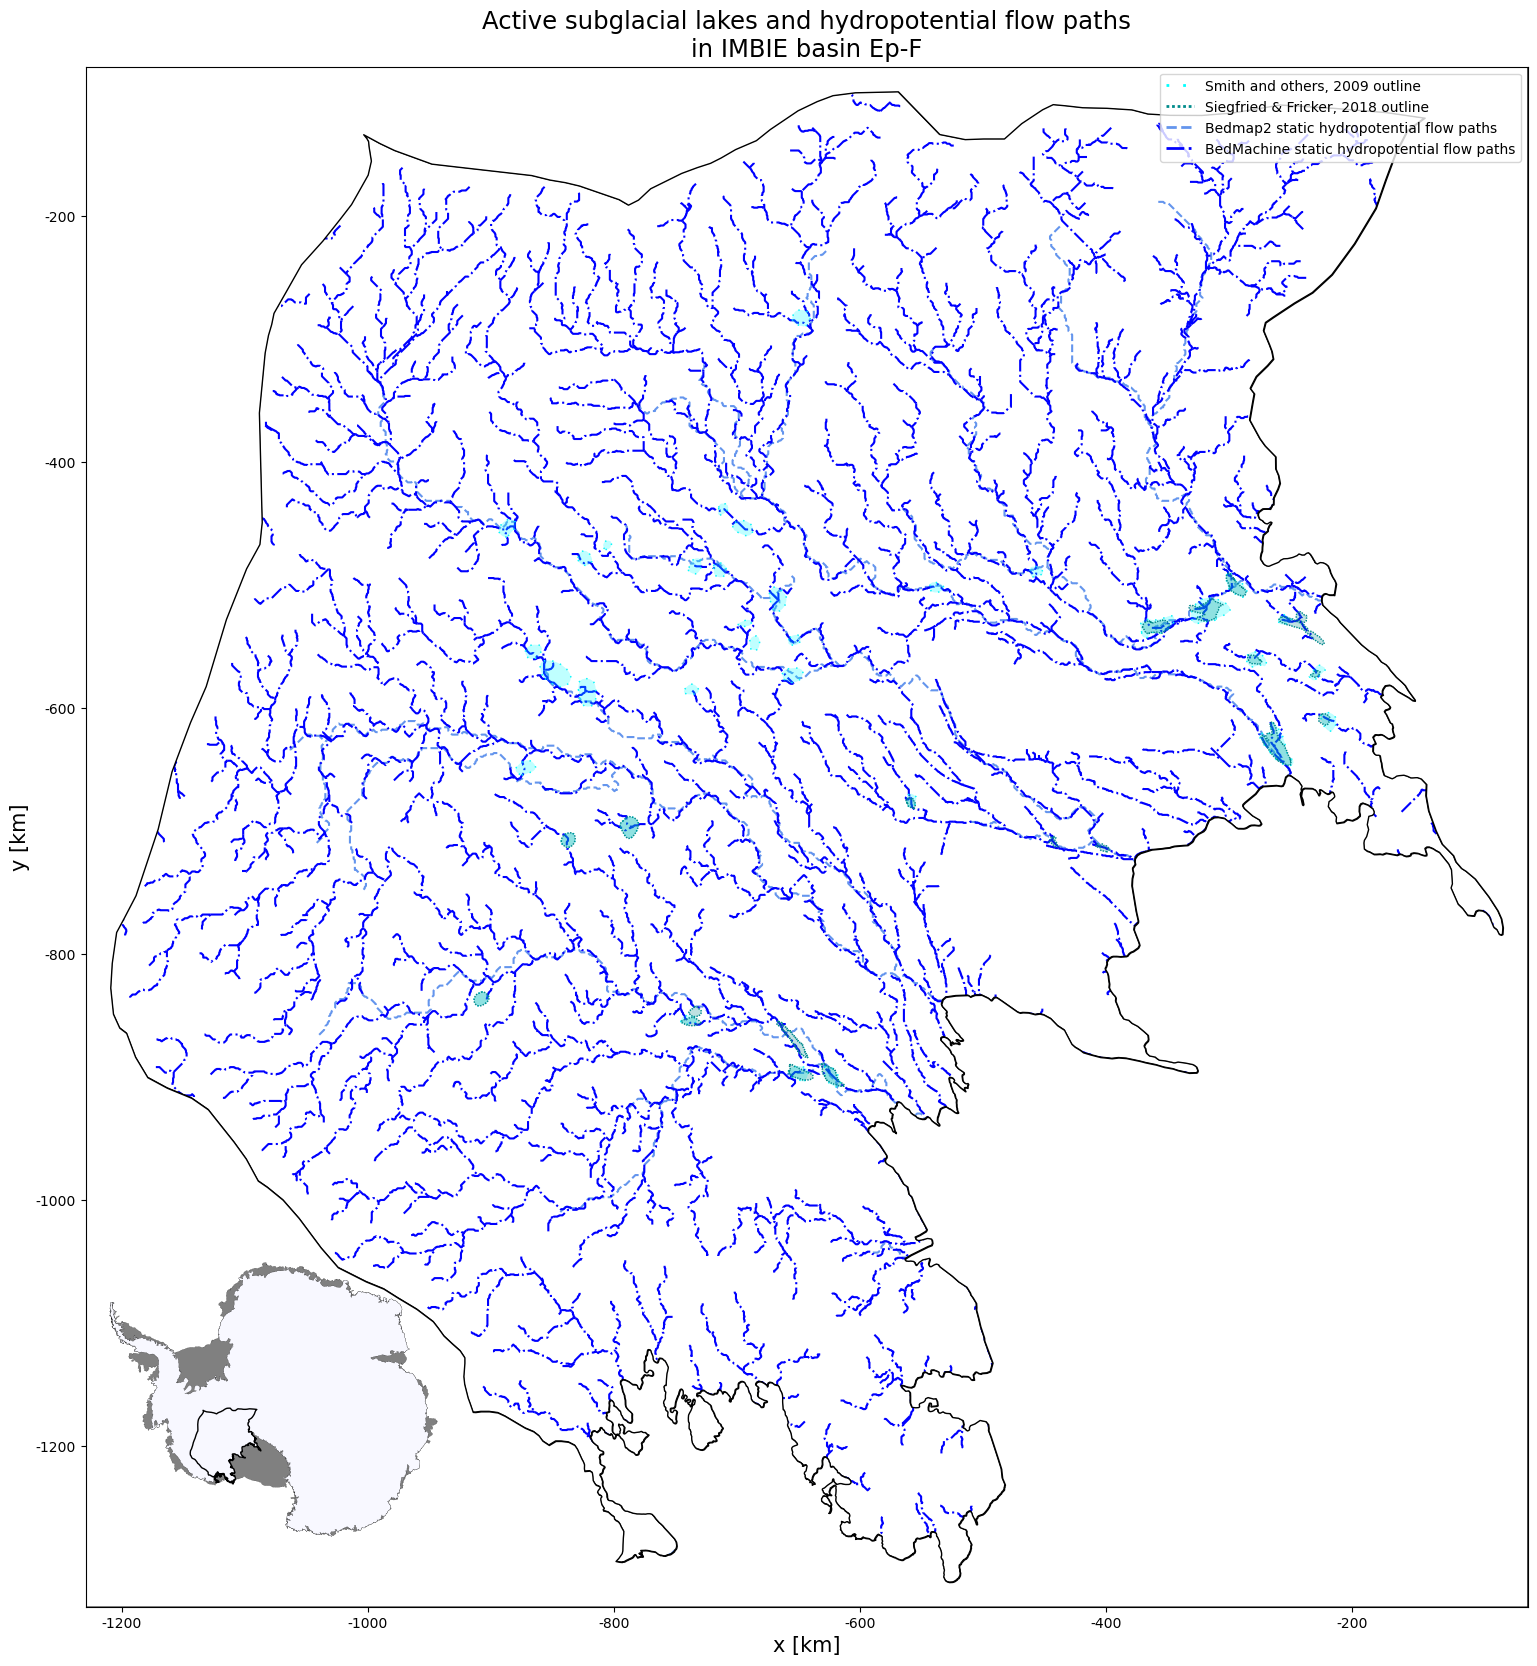

In [69]:
branches_BedMachine = plot_static_subglacial_flow_paths(IMBIE_basins[IMBIE_basins['NAME'] == 'Ep-F'])

In [ ]:
plot_bedmachine_static_subglacial_flow_paths(IMBIE_basins[IMBIE_basins['NAME'] == 'Ep-F'])

In [ ]:
for i, value in enumerate(IMBIE_basins['NAME']):
    if i == 0:  # Skip 0th basin since it is the islands
        continue
    print(f"Processing index {i}/{len(IMBIE_basins)}: basin {value}")
    basin = IMBIE_basins.iloc[[i]]
    plot_IMBIE_basin(basin)

In [54]:
type(branches_BedMachine)

geojson.feature.FeatureCollection

In [70]:
# Extract branches
branches_gdf = gpd.GeoDataFrame.from_features(branches_BedMachine, crs=3031)
branches_gdf_clipped = branches_gdf.clip(Scripps_landice)
branches_gdf_clipped = branches_gdf.clip(IMBIE_basins[IMBIE_basins['NAME'] == 'Ep-F'])

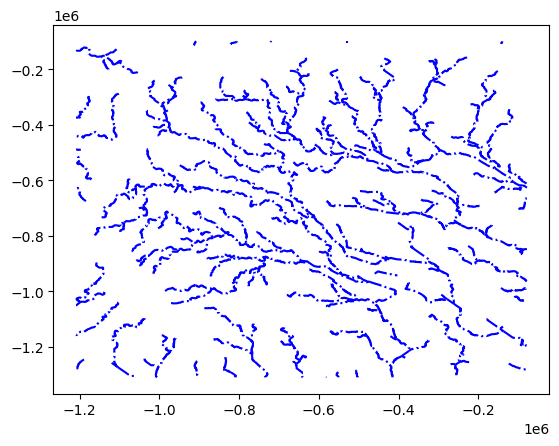

In [57]:
# Basic plot
fig, ax = plt.subplots()

for branch in branches_BedMachine['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    ax.plot(line[:, 0], line[:, 1], linestyle='dashdot', color='blue')

<Axes: >

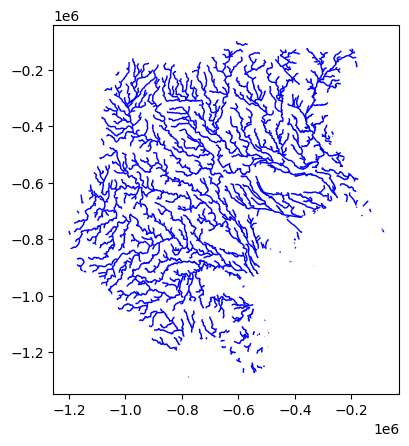

In [71]:
# Basic plot
fig, ax = plt.subplots()
branches_gdf_clipped.plot(ax=ax, color='b', linewidth=1)

In [45]:
# Exporting feature collection branch network for Helen/Byrony 2023-12-23
import geojson
from pathlib import Path
# File path for the output file (replace 'your_path' with your desired path)
output_file_path = Path('flow_paths_Ep-F_Bedmachine_featurecollection.geojson')

# Function to export FeatureCollection to a GeoJSON file
def export_feature_collection_to_file(feature_collection, file_path):
    with open(file_path, 'w') as file:
        geojson.dump(feature_collection, file)

# Export the FeatureCollection
export_feature_collection_to_file(branches_BedMachine, output_file_path)

In [72]:
# Export geodataframe
# branches_gdf.to_file("IS2_branches.shp")
branches_gdf_clipped.to_file("flow_paths_Ep-F_Bedmachine.geojson", driver='GeoJSON')
branches_gdf_clipped.to_file("flow_paths_Ep-F_Bedmachine", layer='branches', driver="GPKG")

# Converting geometry to WKT
# Bedmachine_branches['geometry'] = Bedmachine_branches['geometry'].apply(lambda x: x.wkt)

# Exporting to CSV
branches_gdf_clipped.to_csv('flow_paths_Ep-F_Bedmachine.csv', index=False)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Reading the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file('flow_paths_Ep-F_Bedmachine.geojson')

# Basic plot
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='b', linewidth=1)

<Axes: >

# Collab w hannah on crary ice rise
* Make series of plots demonstrating hydrological connectivity of region

In [39]:
# Bbox for Crary Ice Rise from Hannah
xmin, xmax = (-3e5,0)
ymin, ymax = (-8.5e5, -5.5e5)

# Subset MOA imagery to region of interest using data masks
mask_x = (moa_lowres_da.x >= xmin) & (moa_lowres_da.x <= xmax)
mask_y = (moa_lowres_da.y >= ymin) & (moa_lowres_da.y <= ymax)
moa_lowres_sub = moa_lowres_da.where(mask_x & mask_y, drop=True)

mask_x = (moa_highres_da.x >= xmin) & (moa_highres_da.x <= xmax)
mask_y = (moa_highres_da.y >= ymin) & (moa_highres_da.y <= ymax)
moa_highres_sub = moa_highres_da.where(mask_x & mask_y, drop=True)

# Subset Bedmap2 to region of interest using data masks
mask_x = (Bedmap2_ds.x >= xmin) & (Bedmap2_ds.x <= xmax)
mask_y = (Bedmap2_ds.y >= ymin) & (Bedmap2_ds.y <= ymax)
Bedmap2_ds_sub = Bedmap2_ds.where(mask_x & mask_y, drop=True)

# Subset BedMachine Antarctica to region of interest using data masks
mask_x = (BedMachine_ds.x >= xmin) & (BedMachine_ds.x <= xmax)
mask_y = (BedMachine_ds.y >= ymin) & (BedMachine_ds.y <= ymax)
BedMachine_ds_sub = BedMachine_ds.where(mask_x & mask_y, drop=True)

In [21]:
# Define array
arr = Bedmap2_ds_sub['static_hydropotential_kPa']

# Write CRS
# rio.write_crs()
arr3031 = arr.rio.write_crs("EPSG:3031")

# Specify the output raster file path
output_raster_path = 'output_raster.tif'

# Convert xarray DataArray to raster and save it
arr3031.rio.to_raster(output_raster_path)

grid = pysheds.grid.Grid.from_raster('output_raster.tif')
dem = grid.read_raster('output_raster.tif')

# Delete tiff file
os.remove('output_raster.tif')

# Fill pits
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats and compute flow directions
inflated_dem = grid.resolve_flats(flooded_dem)
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)

# Extract branches
branches = grid.extract_river_network(fdir, acc > 500)
branches_gdf = gpd.GeoDataFrame.from_features(branches, crs=3031)
branches_Bedmap2 = branches_gdf.clip(Scripps_landice)

# Define array
arr = BedMachine_ds_sub['static_hydropotential_kPa']

# Write CRS
# rio.write_crs()
arr3031 = arr.rio.write_crs("EPSG:3031")

# Specify the output raster file path
output_raster_path = 'output_raster.tif'

# Convert xarray DataArray to raster and save it
arr3031.rio.to_raster(output_raster_path)

grid = pysheds.grid.Grid.from_raster('output_raster.tif')
dem = grid.read_raster('output_raster.tif')

# Delete tiff file
os.remove('output_raster.tif')

# Fill pits
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats and compute flow directions
inflated_dem = grid.resolve_flats(flooded_dem)
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)

# Extract branches
branches = grid.extract_river_network(fdir, acc > 500)
branches_gdf = gpd.GeoDataFrame.from_features(branches, crs=3031)
branches_BedMachine = branches_gdf.clip(Scripps_landice)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


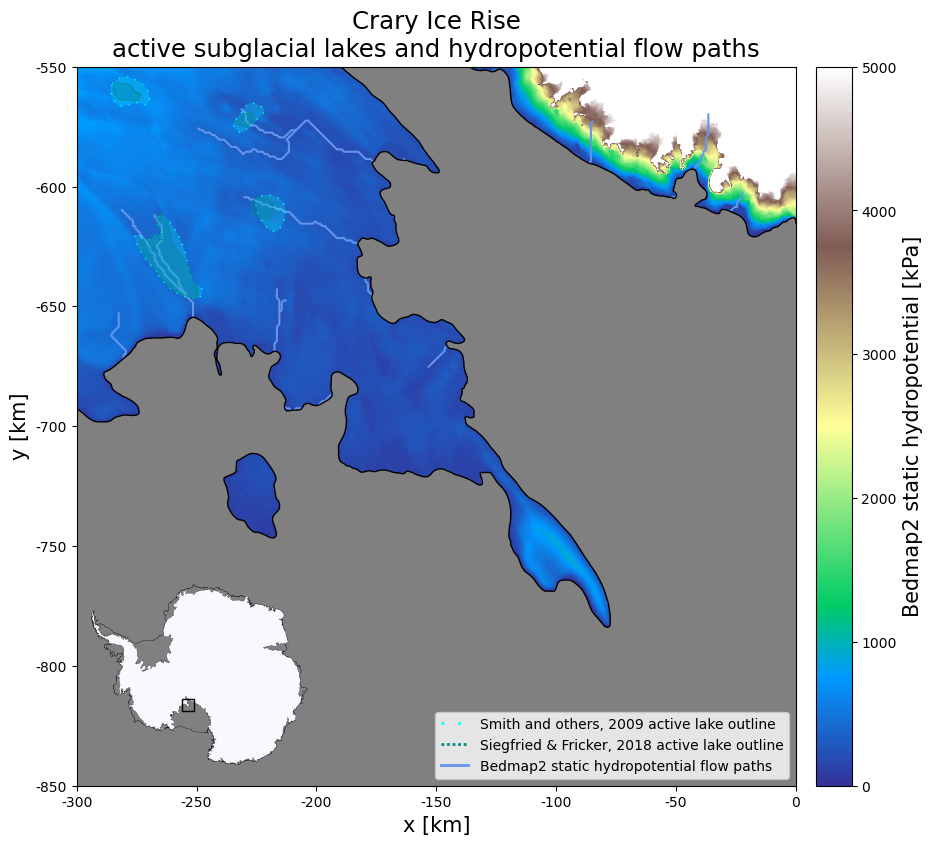

In [51]:
# Create fig, ax
fig, ax = plt.subplots(figsize=(10,10))

# Plot flow paths
branches_Bedmap2.plot(ax=ax, color='cornflowerblue')
# branches_BedMachine.plot(ax=ax, color='blue')

# # Plot MOA surface imagery  
# ax.imshow(moa_highres_sub[0,:,:], cmap="gray", clim=[14000, 17000], extent=[xmin, xmax, ymin, ymax])

# Plot Bedmap2 static hydropotential surface
# im = ax.imshow(Bedmap2_ds_sub['static_hydropotential_kPa'][0,:,:], cmap='terrain', extent=[xmin, xmax, ymin, ymax])
im = ax.imshow(Bedmap2_ds_sub['static_hydropotential_kPa'][0,:,:], cmap='terrain', clim=[0,5000], extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(Bedmap2_ds_sub['grounded_bed_uncertainty'][0,:,:], cmap='Reds', extent=[xmin, xmax, ymin, ymax])

# Plot Bedmachine Antarctica static hydropotential surface
# im = ax.imshow(BedMachine_ds_sub['static_hydropotential_kPa'], cmap='terrain', extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(BedMachine_ds_sub['static_hydropotential_kPa'], cmap='terrain', clim=[0,5000], extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(BedMachine_ds_sub['errbed'], cmap='Reds', extent=[xmin, xmax, ymin, ymax])

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
# Sauthoff2024_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
# Sauthoff2024_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='k', linewidth=1)
# Scripps_landice.plot(ax=ax, color='ghostwhite', linewidth=1)
# Scripps_landice.plot(ax=ax, facecolor='ghostwhite', edgecolor='black', linewidth=1)
# Scripps_icerise.plot(ax=ax, facecolor='ghostwhite', edgecolor='black', linewidth=1)
Scripps_icerise.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
Scripps_iceshelf.plot(ax=ax, facecolor='gray', linewidth=1)

# Create lines for legend
Smith2009 = plt.Line2D((0, 1), (0, 0), color='cyan', linestyle=(0, (1, 5)), linewidth=2)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='darkcyan', linestyle=(0, (1, 1)), linewidth=2)
# Sauthoff2024 = plt.Line2D((0, 1), (0, 0), color='deepskyblue', linestyle=(0, (1, 10)), linewidth=2)
Bedmap2_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='cornflowerblue', linestyle='solid', linewidth=2)
BedMachine_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='blue', linestyle='solid', linewidth=2)

# Create legend
ax.legend([Smith2009, 
           SiegfriedFricker2018, 
           #Sauthoff2024, 
           Bedmap2_hydropotential_branches, 
           # BedMachine_hydropotential_branches, 
        ],
    ['Smith and others, 2009 active lake outline', 
     'Siegfried & Fricker, 2018 active lake outline', 
     #'Sauthoff and others, 2023 outline',
     'Bedmap2 static hydropotential flow paths', 
     # 'BedMachine static hydropotential flow paths',
    ], 
    loc='lower right')

# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_aspect('equal')

# Label axes and set limits
ax.set_xlabel('x [km]', size=15)
ax.set_ylabel('y [km]', size=15)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

# Plot inset map to show location 
axIns = ax.inset_axes([0.005, -0.01, 0.33, 0.33]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.2, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, linewidth=1, color='k', zorder=3)
axIns.add_artist(rect) 
axIns.axis('off')

# Add title
ax.set_title('Crary Ice Rise\nactive subglacial lakes and hydropotential flow paths', pad=7.5, fontsize=17.5)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax).set_label('Bedmap2 static hydropotential [kPa]', size=15)
# fig.colorbar(im, cax=cax).set_label('Bedmap2 bed error [m]', size=15)
# fig.colorbar(im, cax=cax).set_label('Bedmachine static hydropotential [kPa]', size=15)
# fig.colorbar(im, cax=cax).set_label('Bedmachine bed error [m]', size=15)

# Save and close figure
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_hydropotential.png', dpi=300, bbox_inches = "tight")
plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_hydropotential_clim.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_errbed.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_MOA.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_MOA_grayiceshelf.png', dpi=300, bbox_inches = "tight")

# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_hydropotential.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_hydropotential_clim.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_errbed.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_MOA.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_MOA_grayiceshelf.png', dpi=300, bbox_inches = "tight")

# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_BedMachine_static_flow_routing.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_BedMachine_static_flow_routing_MOA.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_BedMachine_static_flow_routing_MOA_grayiceshelf.png', dpi=300, bbox_inches = "tight")

# plt.close()

In [62]:
Scripps_landice.bounds.minx.values[0]

-2507802.8669891283

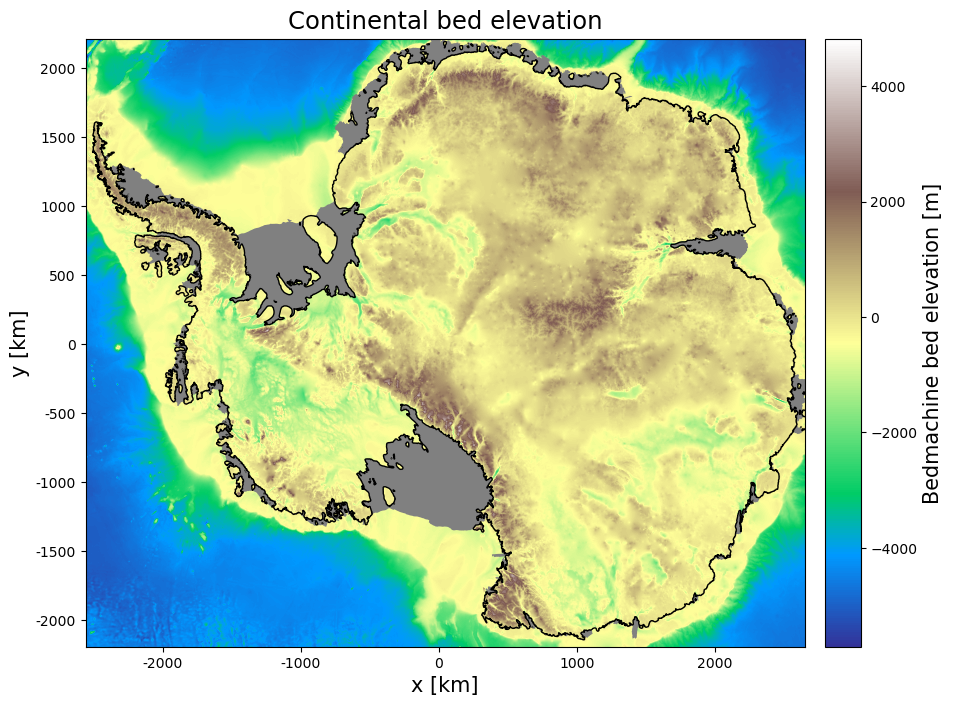

In [70]:
# do ice streams in general have pretty low hydropotentials since they have a lot of water at the base?
buffer = 50e3
xmin, xmax = (Scripps_landice.bounds.minx.values[0]-buffer, Scripps_landice.bounds.maxx.values[0]+buffer)
ymin, ymax = (Scripps_landice.bounds.miny.values[0]-buffer, Scripps_landice.bounds.maxy.values[0]+buffer)

# Subset BedMachine Antarctica to region of interest using data masks
mask_x = (BedMachine_ds.x >= xmin) & (BedMachine_ds.x <= xmax)
mask_y = (BedMachine_ds.y >= ymin) & (BedMachine_ds.y <= ymax)
BedMachine_ds_sub = BedMachine_ds.where(mask_x & mask_y, drop=True)

# Create fig, ax
fig, ax = plt.subplots(figsize=(10,10))

# Plot flow paths
# branches_Bedmap2.plot(ax=ax, color='cornflowerblue')
# branches_BedMachine.plot(ax=ax, color='blue')

# # Plot MOA surface imagery  
# ax.imshow(moa_highres_sub[0,:,:], cmap="gray", clim=[14000, 17000], extent=[xmin, xmax, ymin, ymax])

# Plot Bedmap2 static hydropotential surface
# im = ax.imshow(Bedmap2_ds_sub['static_hydropotential_kPa'][0,:,:], cmap='terrain', extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(Bedmap2_ds_sub['static_hydropotential_kPa'][0,:,:], cmap='terrain', clim=[0,5000], extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(Bedmap2_ds_sub['grounded_bed_uncertainty'][0,:,:], cmap='Reds', extent=[xmin, xmax, ymin, ymax])

# Plot Bedmachine Antarctica static hydropotential surface
im = ax.imshow(BedMachine_ds_sub['bed'], cmap='terrain', extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(BedMachine_ds_sub['static_hydropotential_kPa'], cmap='terrain', extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(BedMachine_ds['static_hydropotential_kPa'], cmap='terrain', clim=[0,5000], extent=[xmin, xmax, ymin, ymax])
# im = ax.imshow(BedMachine_ds_sub['errbed'], cmap='Reds', extent=[xmin, xmax, ymin, ymax])

# Overlay published active lake outlines for visual comparison and grounding line
# Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
# Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
# SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
# SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
# Sauthoff2024_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
# Sauthoff2024_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='k', linewidth=1)
# Scripps_landice.plot(ax=ax, color='ghostwhite', linewidth=1)
# Scripps_landice.plot(ax=ax, facecolor='ghostwhite', edgecolor='black', linewidth=1)
# Scripps_icerise.plot(ax=ax, facecolor='ghostwhite', edgecolor='black', linewidth=1)
Scripps_icerise.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
Scripps_iceshelf.plot(ax=ax, facecolor='gray', linewidth=1)

# Create lines for legend
Smith2009 = plt.Line2D((0, 1), (0, 0), color='cyan', linestyle=(0, (1, 5)), linewidth=2)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='darkcyan', linestyle=(0, (1, 1)), linewidth=2)
# Sauthoff2024 = plt.Line2D((0, 1), (0, 0), color='deepskyblue', linestyle=(0, (1, 10)), linewidth=2)
Bedmap2_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='cornflowerblue', linestyle='solid', linewidth=2)
BedMachine_hydropotential_branches = plt.Line2D((0, 1), (0, 0), color='blue', linestyle='solid', linewidth=2)

# # Create legend
# ax.legend([Smith2009, SiegfriedFricker2018, #Sauthoff2024, 
#            Bedmap2_hydropotential_branches, BedMachine_hydropotential_branches, 
#         ],
#     ['Smith and others, 2009 active lake outline', 'Siegfried & Fricker, 2018 active lake outline', 
#      #'Sauthoff and others, 2023 outline',
#      'Bedmap2 static hydropotential flow paths', 
#      # 'BedMachine static hydropotential flow paths',
#     ], 
#     loc='lower right')

# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_aspect('equal')

# Label axes and set limits
ax.set_xlabel('x [km]', size=15)
ax.set_ylabel('y [km]', size=15)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

# # Plot inset map to show location 
# axIns = ax.inset_axes([0.005, -0.01, 0.33, 0.33]) # [left, bottom, width, height] (fractional axes coordinates)
# axIns.set_aspect('equal')
# moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.2, zorder=3)
# moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
# rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, linewidth=1, color='k', zorder=3)
# axIns.add_artist(rect) 
# axIns.axis('off')

# Add title
ax.set_title('Continental bed elevation', pad=7.5, fontsize=17.5)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
# fig.colorbar(im, cax=cax).set_label('Bedmap2 static hydropotential [kPa]', size=15)
# fig.colorbar(im, cax=cax).set_label('Bedmap2 bed error [m]', size=15)
fig.colorbar(im, cax=cax).set_label('Bedmachine bed elevation [m]', size=15)
# fig.colorbar(im, cax=cax).set_label('Bedmachine bed error [m]', size=15)

# Save and close figure
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_hydropotential.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_hydropotential_clim.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_errbed.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_MOA.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_static_flow_routing_MOA_grayiceshelf.png', dpi=300, bbox_inches = "tight")

# plt.savefig(OUTPUT_DIR + '/Antarctica/BedMachine_static_flow_routing.png', dpi=300, bbox_inches = "tight")
plt.savefig(OUTPUT_DIR + '/Antarctica/BedMachine_bed.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_hydropotential_clim.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_errbed.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_MOA.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/BedMachine_static_flow_routing_MOA_grayiceshelf.png', dpi=300, bbox_inches = "tight")

# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_BedMachine_static_flow_routing.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_BedMachine_static_flow_routing_MOA.png', dpi=300, bbox_inches = "tight")
# plt.savefig(OUTPUT_DIR + '/crary_ice_rise/Bedmap2_BedMachine_static_flow_routing_MOA_grayiceshelf.png', dpi=300, bbox_inches = "tight")

# plt.close()

In [3]:
# Subset to region of interest to 
# Define bounding box
# RecoverySlessorGlaciers
corner1=ll2ps(-5,-78.5)
corner2=ll2ps(-5,-82)
corner3=ll2ps(-36,-78.5)
corner4=ll2ps(-36,-82)
xmin=min(corner1[0],corner2[0],corner3[0],corner4[0])
xmax=max(corner1[0],corner2[0],corner3[0],corner4[0])
ymin=min(corner1[1],corner2[1],corner3[1],corner4[1])
ymax=max(corner1[1],corner2[1],corner3[1],corner4[1])

In [3]:
# Define bounding box
# LowerMercerWhillansIceStreams
corner1=ll2ps(-154,-82)
corner2=ll2ps(-130,-83)
corner3=ll2ps(-130,-85)
corner4=ll2ps(-165,-84.5)
xmin=min(corner1[0],corner2[0],corner3[0],corner4[0])
xmax=max(corner1[0],corner2[0],corner3[0],corner4[0])
ymin=min(corner1[1],corner2[1],corner3[1],corner4[1])
ymax=max(corner1[1],corner2[1],corner3[1],corner4[1])

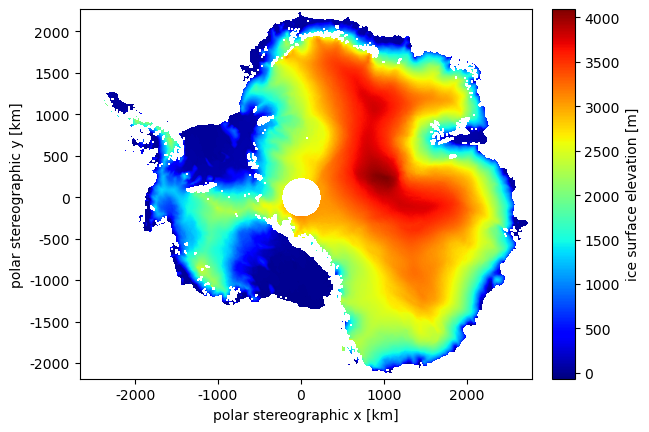

In [15]:
# Plot ice surface height of first time slice to ensure working
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(min(ATL15_dh['x']), max(ATL15_dh['x']))
ax.set_ylim(min(ATL15_dh['y']), max(ATL15_dh['y']))
img = ax.imshow(ATL15_dh['h'][0,:,:], extent=[min(ATL15_dh['x']), max(ATL15_dh['x']), min(ATL15_dh['y']), max(ATL15_dh['y'])], cmap='jet')

# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)  

# Label axes
ax.set_xlabel('polar stereographic x [km]', size=10)
ax.set_ylabel('polar stereographic y [km]', size=10)

# Add colorbar (append to right axis after locating it)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax, label='ice surface elevation [m]')

plt.show()

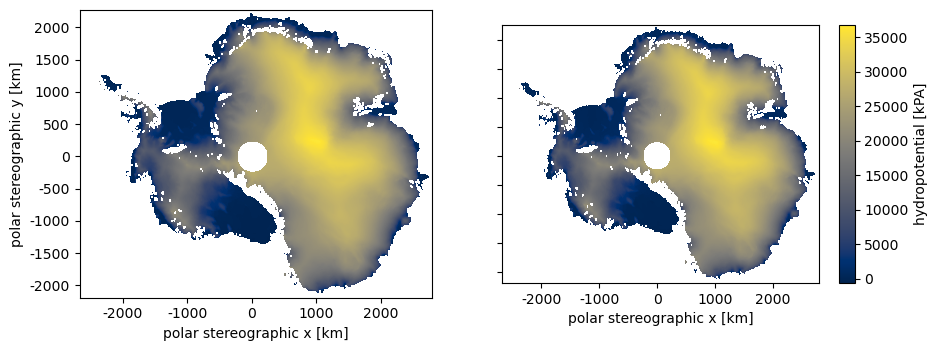

In [18]:
# Plot hydropotential, first time slice
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,10))
ax[0].set_aspect('equal')
ax[0].set_xlim(min(ATL15_dh['x']),max(ATL15_dh['x']))
ax[0].set_ylim(min(ATL15_dh['y']),max(ATL15_dh['y']))
img = ax[0].imshow(ATL15_dh['hydropotential_kPa_BedMachine'][0,:,:], extent=[min(ATL15_dh['x']), max(ATL15_dh['x']), min(ATL15_dh['y']), max(ATL15_dh['y'])], cmap='cividis')
# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax[0].xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax[0].yaxis.set_major_formatter(ticks_y)  
# Label axes
ax[0].set_xlabel('polar stereographic x [km]', size=10)
ax[0].set_ylabel('polar stereographic y [km]', size=10)
# Repeat for Bedmap2 hydrotential
ax[1].set_aspect('equal')
ax[1].set_xlim(min(ATL15_dh['x']),max(ATL15_dh['x']))
ax[1].set_ylim(min(ATL15_dh['y']),max(ATL15_dh['y']))
img = ax[1].imshow(ATL15_dh['hydropotential_kPa_Bedmap2'][0,:,:], extent=[min(ATL15_dh['x']), max(ATL15_dh['x']), min(ATL15_dh['y']), max(ATL15_dh['y'])], cmap='cividis')
# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax[1].xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax[1].yaxis.set_major_formatter(ticks_y)  
# Label axis
ax[1].set_xlabel('polar stereographic x [km]', size=10)
# Add colorbar
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax, label='hydropotential [kPa]')
plt.show()

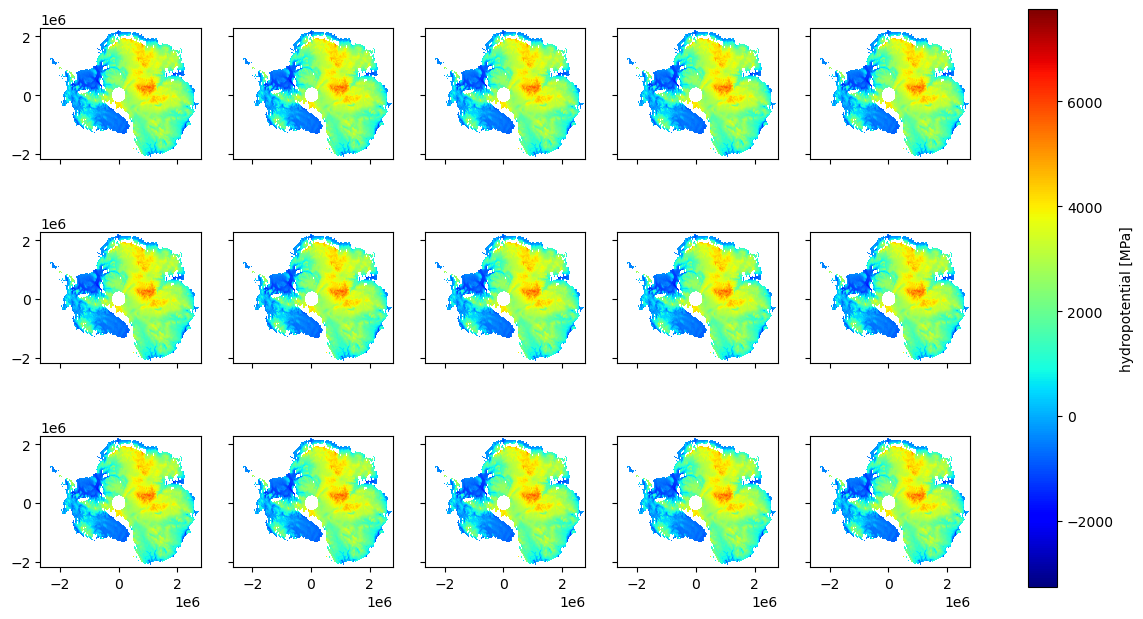

In [120]:
xmin = min(ATL15_dh['x'])
xmax = max(ATL15_dh['x'])
ymin = min(ATL15_dh['y'])
ymax = max(ATL15_dh['y'])

# Plot hydropotential, all time slices
fig, axes = plt.subplots(3,5, sharex=True, sharey=True, figsize=(15,7.5))
for i, ax in enumerate(fig.axes): 
    ax.set_aspect('equal')
    ax.set_xlim(min(ATL15_dh['x']),max(ATL15_dh['x']))
    ax.set_ylim(min(ATL15_dh['y']),max(ATL15_dh['y']))
    im = ax.imshow(ATL15_dh['hydropotential_kPa_BedMachine'][i,:,:], extent=[min(ATL15_dh['x']), max(ATL15_dh['x']), min(ATL15_dh['y']), max(ATL15_dh['y'])], cmap='jet')
fig.colorbar(im, ax=axes.ravel().tolist(), label='hydropotential [kPa]')
plt.show()

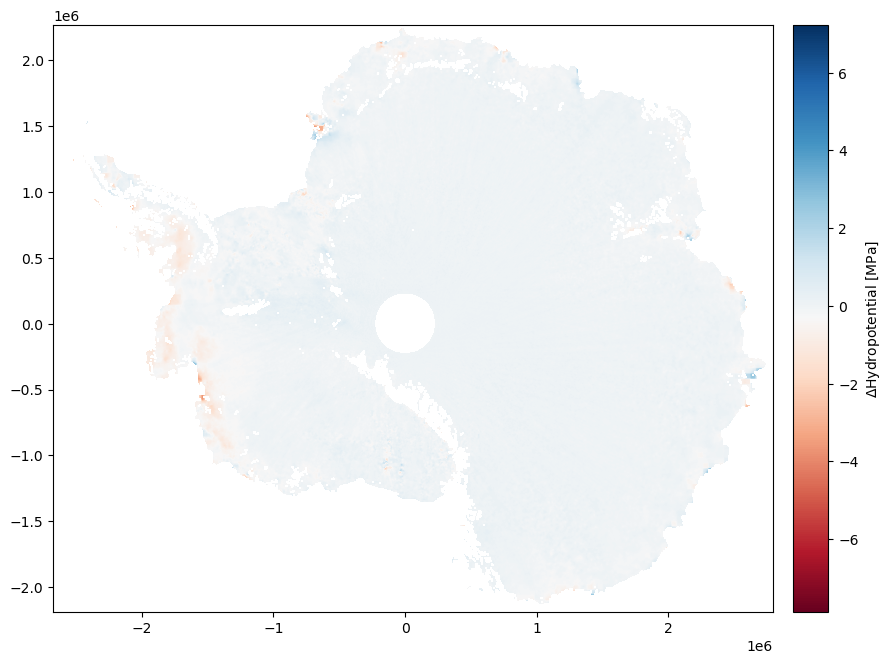

In [92]:
# Plot delta hydropotential, first minus zeroth time slice
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
img = ax.imshow(ATL15_dh['hydropotential_MPa'][1,:,:] - ATL15_dh['hydropotential_MPa'][0,:,:], extent=[xmin,xmax,ymin,ymax], cmap='RdBu')
fig.colorbar(img, cax=cax, label='$\Delta$Hydropotential [MPa]')
plt.show()

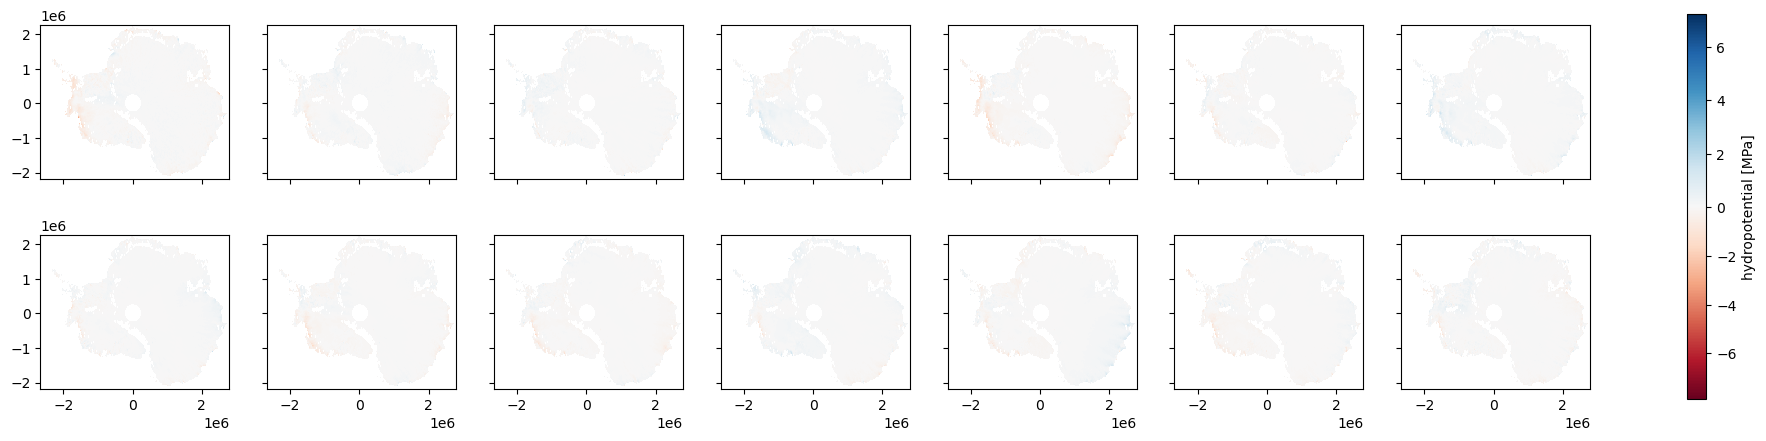

In [123]:
# Plot changes in hydropotential at each slice
# Diverge from zero
divnorm=colors.TwoSlopeNorm(vcenter=0.)
# Plot hydropotential differences between quarterly ICESat-2 orbital repeats 
fig, axes = plt.subplots(2,7, sharex=True, sharey=True, figsize=(25,5))
for i, ax in enumerate(fig.axes): 
    ax.set_aspect('equal')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    im = ax.imshow((ATL15_dh['hydropotential_MPa'][i+1,:,:] - ATL15_dh['hydropotential_MPa'][i,:,:]), extent=[xmin,xmax,ymin,ymax], cmap='RdBu', norm=divnorm)
fig.colorbar(im, ax=axes.ravel().tolist(), label='hydropotential [MPa]')
plt.show()

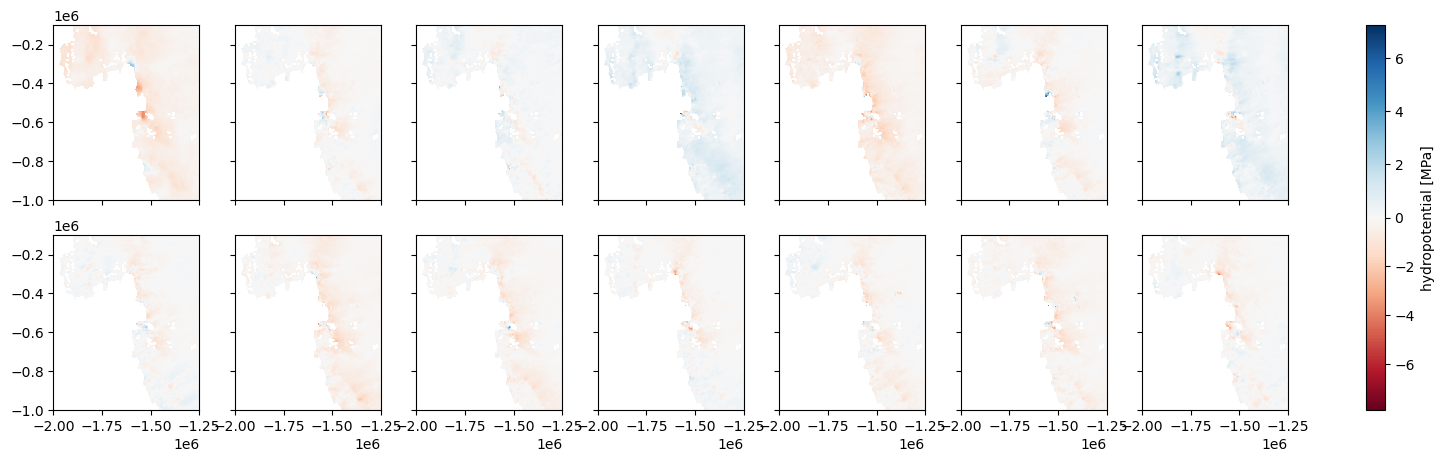

In [124]:
# Let's zoom into Amundsen Sea region to examine how changes in ice surface height are influencing hydropotential
xmin = -2000000
xmax = -1250000
ymin = -1000000
ymax = -100000
# Subset ATL15 data set to region of interest
dataset = ATL15_dh
mask_x = (dataset.x >= xmin) & (dataset.x <= xmax)
mask_y = (dataset.y >= ymin) & (dataset.y <= ymax)
ATL15_dh_sub = dataset.where(mask_x & mask_y, drop=True)
# Plot hydropotential differences since 
fig, axes = plt.subplots(2,7, sharex=True, sharey=True, figsize=(20,5))
for i, ax in enumerate(fig.axes): 
    ax.set_aspect('equal')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    im = ax.imshow((ATL15_dh_sub['hydropotential_MPa'][i+1,:,:] - ATL15_dh_sub['hydropotential_MPa'][i,:,:]), extent=[xmin,xmax,ymin,ymax], cmap='RdBu', norm=divnorm)
fig.colorbar(im, ax=axes.ravel().tolist(), label='hydropotential [MPa]')
plt.show()

In [116]:
# Let's zoom into into the Thwaites lakes area
xmax = -1360000
xmin = -1480000
ymin = -465000
ymax = -375000

In [14]:
# Define bounding box
# RecoverySlessorGlaciers
corner1=ll2ps(-5,-78.5)
corner2=ll2ps(-5,-82)
corner3=ll2ps(-36,-78.5)
corner4=ll2ps(-36,-82)
xmin=min(corner1[0],corner2[0],corner3[0],corner4[0])
xmax=max(corner1[0],corner2[0],corner3[0],corner4[0])
ymin=min(corner1[1],corner2[1],corner3[1],corner4[1])
ymax=max(corner1[1],corner2[1],corner3[1],corner4[1])

In [ ]:
# Clip BedMachine_ds to Siple Coast IMBIE basin
BedMachine_ds = BedMachine_ds.clip

In [7]:
arr = BedMachine_ds['static_hydropotential_kPa']
tif_file = rasterio.open('test1.tif', 'w', driver='GTiff',
                         height = arr.shape[0], width = arr.shape[1],
                         count=1, dtype=str(arr.dtype),
                         crs='+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs',
                         transform=rasterio.transform.from_origin(xmin, ymax, (xmax-xmin)/arr.shape[1], (ymax-ymin)/arr.shape[0]), # (west, north, xsize, ysize)
                         nodata=-9999.0)

tif_file.write(BedMachine_ds['static_hydropotential_kPa'], 1)
tif_file.close()

In [8]:
# Instantiate grid from raster
# grid = Grid.from_raster(dataset_sub['hydropotential_kPa'].values)
# dem = grid.read_raster(dataset_sub['hydropotential_kPa'].values)
from pysheds.grid import Grid
grid = Grid.from_raster('test1.tif')
dem = grid.read_raster('test1.tif')

# Fill pits
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats and compute flow directions
inflated_dem = grid.resolve_flats(flooded_dem)
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)

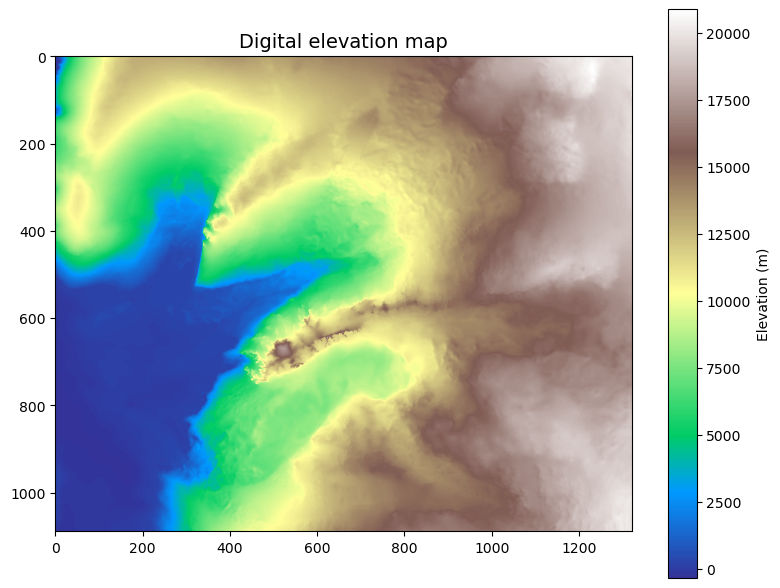

In [17]:
# Plot the raw DEM
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.view(dem), cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital elevation map', size=14)
plt.tight_layout()

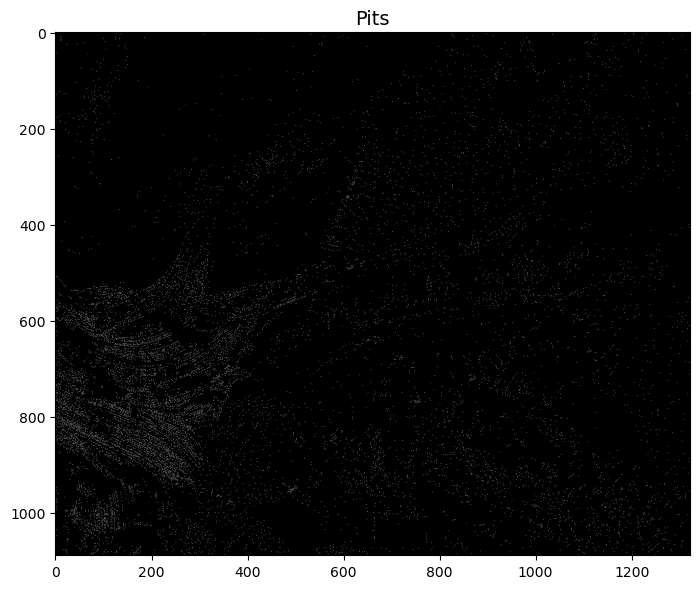

In [18]:
# Detect pits
pits = grid.detect_pits(dem)

# Plot pits
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pits, cmap='Greys_r', zorder=1)
plt.title('Pits', size=14)
plt.tight_layout()

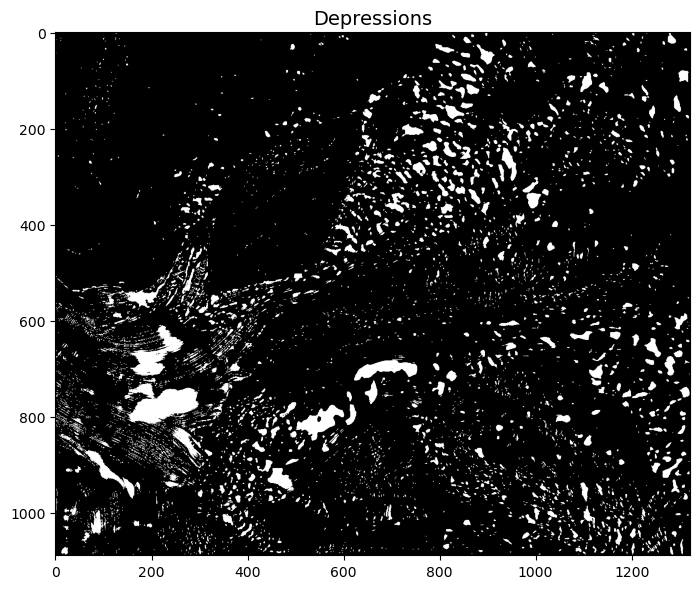

In [19]:
# Detect depressions
depressions = grid.detect_depressions(pit_filled_dem)

# Plot depressions
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap='Greys_r', zorder=1)
plt.title('Depressions', size=14)
plt.tight_layout()

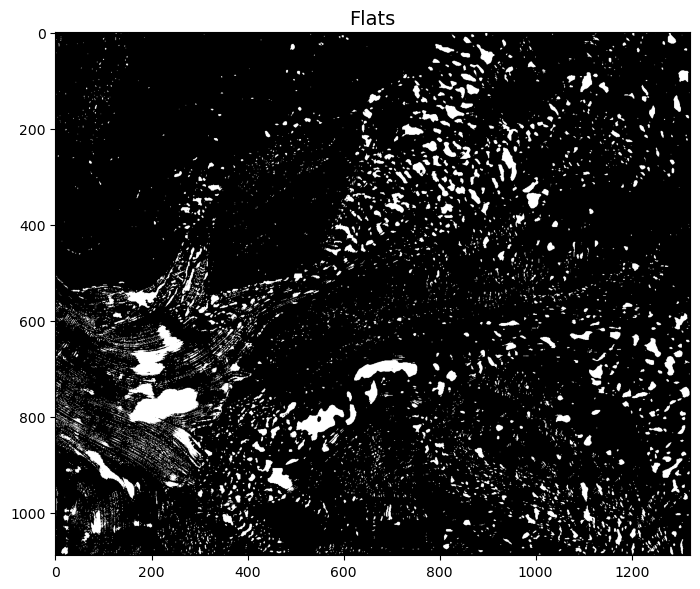

In [20]:
# Detect flats
flats = grid.detect_flats(flooded_dem)

# Plot flats
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(flats, cmap='Greys_r', zorder=1)
plt.title('Flats', size=14)
plt.tight_layout()

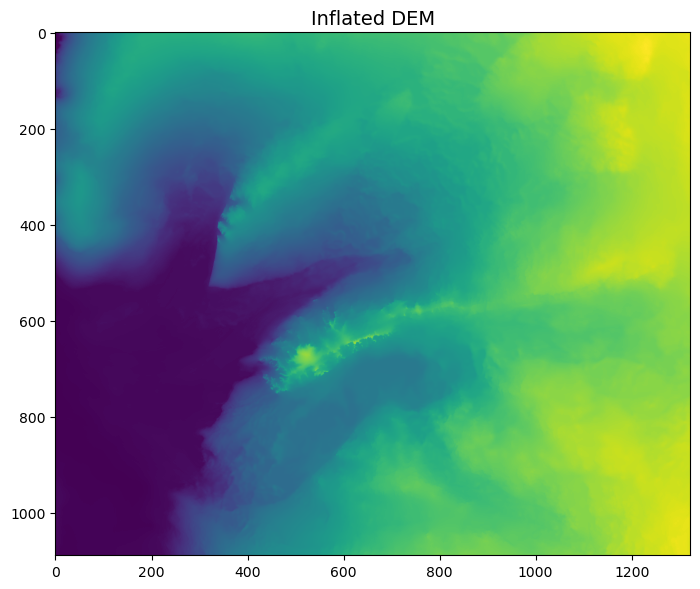

In [21]:
# Plot inflated dem
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(inflated_dem)
plt.title('Inflated DEM', size=14)
plt.tight_layout()

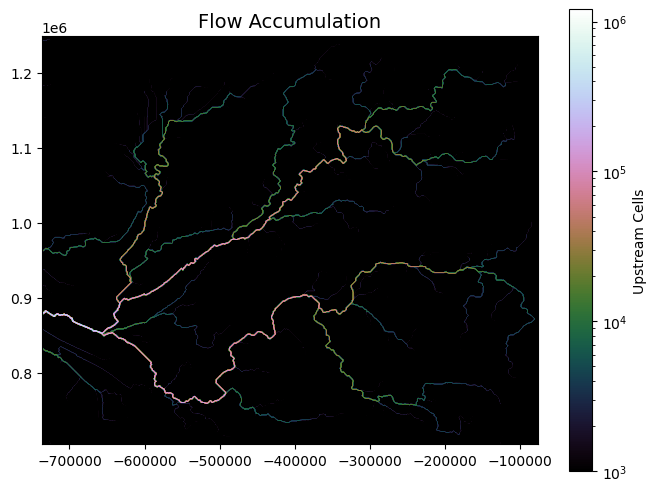

In [22]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1000, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
plt.show()

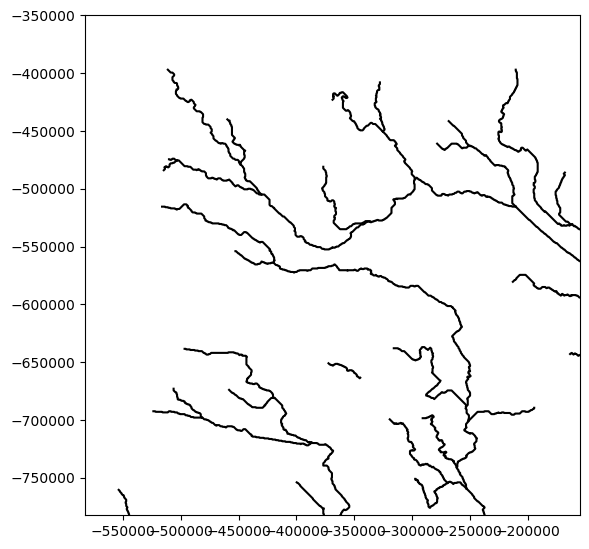

In [9]:
branches = grid.extract_river_network(fdir, acc > 10000)

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='k')
    
# _ = plt.title('Channel network (>100 accumulation)', size=14)

In [11]:
from geojson import Point, Feature, FeatureCollection, dump
with open('mercerwhillans_branches.geojson', 'w') as f:
   dump(branches, f)

In [25]:
np.array(acc)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  6., ...,  1.,  1.,  0.],
       [ 1., 13.,  6., ...,  2.,  1.,  0.],
       ...,
       [ 0.,  1.,  2., ...,  1.,  2.,  2.],
       [ 0.,  1.,  2., ...,  4.,  5.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [28]:
np.save('BedMachine_pyshedsacc_SlessorRecovery', np.array(acc))

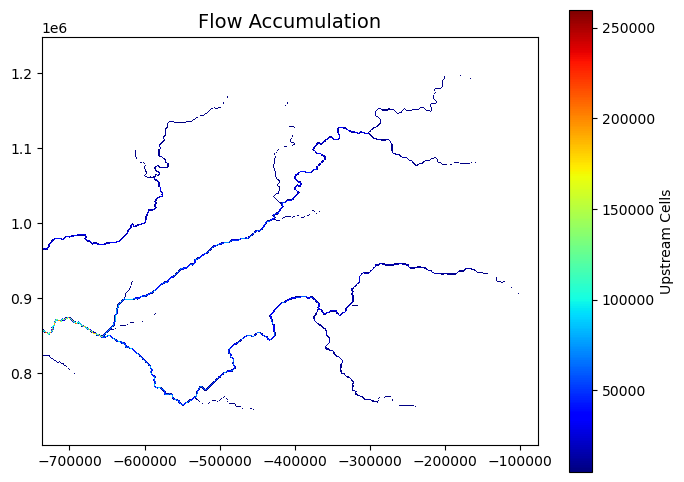

In [22]:
# Making function to plot subglacial flow routing for a region

# Define bounding box
# RecoverySlessorGlaciers
corner1=ll2ps(-5,-78.5)
corner2=ll2ps(-5,-82)
corner3=ll2ps(-36,-78.5)
corner4=ll2ps(-36,-82)
xmin=min(corner1[0],corner2[0],corner3[0],corner4[0])
xmax=max(corner1[0],corner2[0],corner3[0],corner4[0])
ymin=min(corner1[1],corner2[1],corner3[1],corner4[1])
ymax=max(corner1[1],corner2[1],corner3[1],corner4[1])

# Subset dataset to region of interest
dataset = BedMachine_ds
mask_x = (dataset.x >= xmin) & (dataset.x <= xmax)
mask_y = (dataset.y >= ymin) & (dataset.y <= ymax)
dataset_sub = dataset.where(mask_x & mask_y, drop=True)

# Create new .tif file
# arr = dataset_sub['static_hydropotential_kPa']
arr = ATL15_dh['dynamic_hydropotential_kPa_BedMachine'][0,:,:]
tif_file = rasterio.open('test1.tif', 'w', driver='GTiff',
                         height = arr.shape[0], width = arr.shape[1],
                         count=1, dtype=str(arr.dtype),
                         crs='+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs',
                         transform=rasterio.transform.from_origin(xmin, ymax, 0.5, 0.5), # (west, north, xsize, ysize) # NEED TO FIGURE OUT PIXEL SIZE
                         nodata=-9999.0)
tif_file.write(arr, 1)
tif_file.close()

# Instantiate grid from raster
grid = pysheds.grid.Grid.from_raster('test1.tif')
dem = grid.read_raster('test1.tif')

# Fill pits
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats and compute flow directions
inflated_dem = grid.resolve_flats(flooded_dem)
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)

# Make new colormap for plotting purposes
my_cmap = mpl.cm.get_cmap('jet').copy()
my_cmap.set_under('k', alpha=0)

# Plot accumulation
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(acc, 
    extent=[xmin, xmax, ymin, ymax], 
    zorder=2,
    cmap=my_cmap,
    clim=[5000, acc.max()])
    # interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
plt.show()

In [80]:
# Making function to plot dynamic subglacial flow routing for a region

# Define bounding box
# # lowerMercerWhillansIceStreams
# corner1=ll2ps(-154,-82)
# corner2=ll2ps(-130,-83)
# corner3=ll2ps(-130,-85)
# corner4=ll2ps(-165,-84.5)
# xmin=min(corner1[0],corner2[0],corner3[0],corner4[0])
# xmax=max(corner1[0],corner2[0],corner3[0],corner4[0])
# ymin=min(corner1[1],corner2[1],corner3[1],corner4[1])
# ymax=max(corner1[1],corner2[1],corner3[1],corner4[1])

# lowerMercerWhillansIceStreams
xmin=-575e3
xmax=-200e3
ymin=-650e3
ymax=-400e3

# # Subset to region of interest to 
# # Define bounding box
# # RecoverySlessorGlaciers
# corner1=ll2ps(-5,-78.5)
# corner2=ll2ps(-5,-82)
# corner3=ll2ps(-36,-78.5)
# corner4=ll2ps(-36,-82)
# xmin=min(corner1[0],corner2[0],corner3[0],corner4[0])
# xmax=max(corner1[0],corner2[0],corner3[0],corner4[0])
# ymin=min(corner1[1],corner2[1],corner3[1],corner4[1])
# ymax=max(corner1[1],corner2[1],corner3[1],corner4[1])

# Open Bedmachine netcdf dataset using xarray
# BedMachine_ds = xr.open_dataset(DATA_DIR + '/beds/BedMachine/BedMachineAntarctica_2020-07-15_v02.nc')
# Subset dataset to region of interest using data masks
dataset = BedMachine_ds
mask_x = (dataset.x >= xmin) & (dataset.x <= xmax)
mask_y = (dataset.y >= ymin) & (dataset.y <= ymax)
BedMachine_ds_sub = dataset.where(mask_x & mask_y, drop=True)

dataset1 = CS2_dh
mask_x = (dataset1.x >= xmin) & (dataset1.x <= xmax)
mask_y = (dataset1.y >= ymin) & (dataset1.y <= ymax)
ATL15_dh_sub = dataset1.where(mask_x & mask_y, drop=True)

# # file = DATA_DIR + '/altimetry/ICESat2/ATL14.002-Ant/ATL14_AA_0314_100m_002_02.nc'
# # ATL14_dh = rioxarray.open_rasterio(file, masked=True)
# # Just look at essential data
# ATL14_dh = ATL14
# ATL14_dh = ATL14_dh[0]
# # Drop band dimension from data variables
# # ATL14_dh['ice_area'] = ATL14_dh['ice_area'].sel(band=1)
# ATL14_dh['h'] = ATL14_dh['h'].sel(band=1)
# # FIXME: loading fewer variables to save memory
# # ATL14_dh['h_sigma'] = ATL14_dh['h_sigma'].sel(band=1)
# # ATL14_dh['data_count'] = ATL14_dh['data_count'].sel(band=1)
# # ATL14_dh['misfit_rms'] = ATL14_dh['misfit_rms'].sel(band=1)
# # ATL14_dh['misfit_scaled_rms'] = ATL14_dh['misfit_scaled_rms'].sel(band=1)
# # Drop unneeded coordinates and dimension
# ATL14_dh = ATL14_dh.drop_vars('Polar_Stereographic')
# ATL14_dh = ATL14_dh.drop_dims('band')
# granule = 's3://is2view/ATLAS/ATL14/002/2019/ATL14_AA_0314_100m_002_02.nc'
# ATL14_dh = rioxarray.open_rasterio(granule, masked=True)
# subset dataset to region of interest using data masks
dataset = ATL14
mask_x = (dataset.x >= xmin) & (dataset.x <= xmax)
mask_y = (dataset.y >= ymin) & (dataset.y <= ymax)
ATL14_sub = dataset.where(mask_x & mask_y, drop=True)

# file = DATA_DIR + '/altimetry/ICESat2/ATL15.002-Ant/ATL15_AA_0314_01km_002_02.nc'
# ATL15_dh = rioxarray.open_rasterio(file, group='delta_h', masked=True)
# Drop unneeded coordinates
# ATL15_dh = ATL15_dh.drop_vars('Polar_Stereographic')
# ATL15_dh
# Subset dataset to region of interest using data masks
dataset2 = ATL15_dh
mask_x = (dataset2.x >= xmin) & (dataset2.x <= xmax)
mask_y = (dataset2.y >= ymin) & (dataset2.y <= ymax)
ATL15_dh_sub = dataset2.where(mask_x & mask_y, drop=True)
# Assign new data variable of absolute heights (ATL14 DEM + ATL15 dh) to ATL15_dh xarray.Dataset
# ATL15_dh = ATL15_dh.assign(h = ATL15_dh['delta_h'] + ATL14_dh['h'][:,:])
# ATL15_dh = ATL15_dh.assign(dynamic_hydropotential_kPa_BedMachine = (9.8 * (917*ATL15_dh['h'] + (997-917)*BedMachine_ds['bed'])/1e3))

In [81]:
# Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []

for idx in range(len(dataset1.delta_h[:33])):
    # Smith and others, 2017 method CryoSat-2 SARIn data
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
        cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

for idx in range(len(dataset2.delta_h)-1): 
    cyc_start_date = dataset2.time.values[idx]
    cyc_end_date = dataset2.time.values[idx+1]
    midcyc_days = cyc_end_date - cyc_start_date
    midcyc_date = cyc_start_date + midcyc_days/2
    cyc_start_dates += [cyc_start_date]
    cyc_end_dates += [cyc_end_date]
    midcyc_dates += [midcyc_date]

In [82]:
midcyc_dates

[datetime.datetime(2010, 8, 17, 6, 45),
 datetime.datetime(2010, 11, 16, 11, 15),
 datetime.datetime(2011, 2, 15, 15, 45),
 datetime.datetime(2011, 5, 17, 23, 15),
 datetime.datetime(2011, 8, 17, 6, 45),
 datetime.datetime(2011, 11, 16, 11, 15),
 datetime.datetime(2012, 2, 15, 15, 45),
 datetime.datetime(2012, 5, 16, 23, 15),
 datetime.datetime(2012, 8, 16, 6, 45),
 datetime.datetime(2012, 11, 15, 23, 15),
 datetime.datetime(2013, 2, 15, 15, 45),
 datetime.datetime(2013, 5, 17, 23, 15),
 datetime.datetime(2013, 8, 17, 6, 45),
 datetime.datetime(2013, 11, 16, 11, 15),
 datetime.datetime(2014, 2, 15, 15, 45),
 datetime.datetime(2014, 5, 17, 23, 15),
 datetime.datetime(2014, 8, 17, 6, 45),
 datetime.datetime(2014, 11, 16, 11, 15),
 datetime.datetime(2015, 2, 15, 15, 45),
 datetime.datetime(2015, 5, 17, 23, 15),
 datetime.datetime(2015, 8, 17, 6, 45),
 datetime.datetime(2015, 11, 16, 11, 15),
 datetime.datetime(2016, 2, 15, 15, 45),
 datetime.datetime(2016, 5, 16, 23, 15),
 datetime.dateti

In [90]:
[mdates.date2num(midcyc_dates[i]) for i in range(len(midcyc_dates))]

[14838.28125,
 14929.46875,
 15020.65625,
 15111.96875,
 15203.28125,
 15294.46875,
 15385.65625,
 15476.96875,
 15568.28125,
 15659.96875,
 15751.65625,
 15842.96875,
 15934.28125,
 16025.46875,
 16116.65625,
 16207.96875,
 16299.28125,
 16390.46875,
 16481.65625,
 16572.96875,
 16664.28125,
 16755.46875,
 16846.65625,
 16937.96875,
 17029.28125,
 17120.96875,
 17212.65625,
 17303.96875,
 17395.28125,
 17486.46875,
 17577.65625,
 17668.96875,
 17760.28125,
 17851.59375,
 17942.90625,
 18034.21875,
 18125.53125,
 18216.84375,
 18308.15625,
 18399.46875,
 18490.78125,
 18582.09375,
 18673.40625,
 18764.71875,
 18856.03125,
 18947.34375,
 19038.65625,
 19129.96875,
 19221.28125,
 19312.59375,
 19403.90625]

/tmp/ipykernel_144/3831903723.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis_r', len(ATL15_dh['time'].values))
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` 

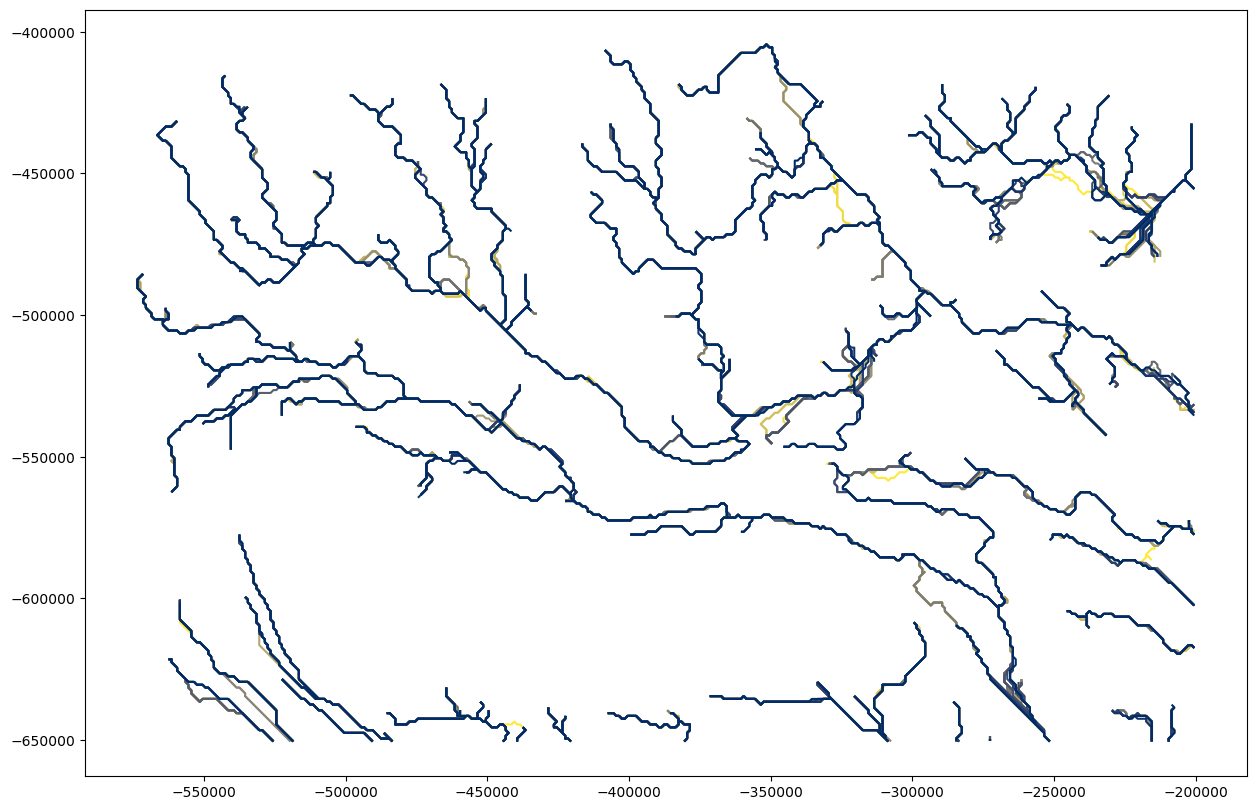

In [99]:
# Set up figure
fig, ax = plt.subplots(figsize=(15,15))

# Pick colormap and make continuous cmap discrete
# cmap = cm.get_cmap('viridis', len(ATL15_dh['dynamic_hydropotential_kPa_BedMachine']))
cmap2 = cm.get_cmap('cividis_r', len(ATL15_dh['time'].values))
# cmap = cm.get_cmap('cividis_r', len(midcyc_dates))

# Norm to time variable
norm2 = plt.Normalize(mdates.date2num(ATL15_dh['time'][0].values), 
                     mdates.date2num(ATL15_dh['time'][-1].values))
# norm = plt.Normalize(mdates.date2num(midcyc_dates[0]), 
#                      mdates.date2num(midcyc_dates[-1]))  
    
for idx in range(len(ATL15_dh['time'].values)-1):
# for idx in range(len(midcyc_dates)-1):

# Define array
    # arr = ATL15_dh_sub['dynamic_hydropotential_kPa_BedMachine'][idx[0], :,:]
    arr = ATL15_dh_sub['dynamic_hydropotential_kPa_BedMachine'][idx, :,:]

    # Write CRS
    # rio.write_crs()
    arr3031 = arr.rio.write_crs("EPSG:3031")
    
    # Specify the output raster file path
    output_raster_path = 'output_raster.tif'
    
    # Convert xarray DataArray to raster and save it
    arr3031.rio.to_raster(output_raster_path)
        
    grid = pysheds.grid.Grid.from_raster('output_raster.tif')
    dem = grid.read_raster('output_raster.tif')
    
    # Delete tiff file
    os.remove('output_raster.tif')

    # Fill pits
    pit_filled_dem = grid.fill_pits(dem)

    # Fill depressions
    flooded_dem = grid.fill_depressions(pit_filled_dem)

    # Resolve flats and compute flow directions
    inflated_dem = grid.resolve_flats(flooded_dem)
    fdir = grid.flowdir(inflated_dem)
    
    # Compute accumulation
    acc = grid.accumulation(fdir)

    # Extract branches
    branches = grid.extract_river_network(fdir, acc > 500)
    branches_gdf = gpd.GeoDataFrame.from_features(branches, crs=3031)
    branches_BedMachine = branches_gdf.clip(Scripps_landice)

    # for idx in enumerate(ATL15_dh['time'].values):
    branches_gdf.plot(ax=ax, color=cmap2(norm2(mdates.date2num(ATL15_dh['time'][idx].values))))
    # branches_gdf.plot(ax=ax, color=cmap(norm(mdates.date2num(midcyc_dates[idx]))))
    
plt.show()

## References
* Shreve, R. L. (1972). Movement of Water in Glaciers. Journal of Glaciology, 11(62), 205–214. https://doi.org/10.3189/S002214300002219X